In [2]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data
from libs.visual_analysis import visualize_fit, visualize_predict
import calendar
import numpy as np
import pandas as pd
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

# Prison

In [3]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['Date'] = prison['t'].astype('datetime64[ns]')
prison = prison.drop('t', axis=1)
prison = prison.set_index('Date')
prison.columns= ['State', 'Gender', 'Legal', 'Count']

In [5]:
prison.to_csv('../data/prison_to_r.csv')

# Tourism

In [8]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)

data_ = data.reset_index().melt(id_vars=['t'],
                                var_name='Groups',
                                value_name='Count')

top50 = data_.groupby('Groups').sum()['Count'].reset_index().sort_values(by=['Count'], ascending=False)[0:50]['Groups'].unique()
data = data.loc[:, data.columns.isin(top50)]

groups_input = {
    'State': [0,1],
    'Zone': [0,2],
    'Region': [0,3],
    'Purpose': [3,6]
}

groups = generate_groups_data(data, groups_input, seasonality=12, h=12)

Number of groups: 4
	State: 6
	Zone: 18
	Region: 29
	Purpose: 4
Total number of series: 50
Number of points per series for train: 216
Total number of points: 228
Seasonality: 12
Forecast horizon: 12


In [11]:
def prepare_data_to_R(groups, date_points):
    idx = {}
    for group in groups['predict']['groups_names'].keys():
        idx[group] = groups['predict']['groups_names'][group][groups['predict']['groups_idx'][group]]
    
    idx['Count'] = groups['predict']['data']
    idx['Date'] = np.tile(date_points, (groups['predict']['s'],))

    df = pd.DataFrame.from_dict(idx)
    df = df.set_index('Date')
    
    return df

In [10]:
tourism = prepare_data_to_R(groups, data.index)
tourism.to_csv('../data/tourism_to_r.csv')

# Police

In [3]:
police = pd.read_excel('../data/NIBRSPublicView.Jan1-Nov30-2020.xlsx')

police = police.drop(['Occurrence\nHour', 'StreetName', 'Suffix', 'NIBRSDescription', 'Premise'], axis=1)
police.columns = ['Id','Date', 'Crime', 'Count', 'Beat', 'Block', 'Street', 'City', 'ZIP']
police = police.drop(['Id'], axis=1)
police = police.loc[police['City']=='HOUSTON']
police = police.drop(['City'], axis=1)

# I am not using Block since there are 11901 blocks in the data
police = police.groupby(['Date', 'Crime', 'Beat', 'Street', 'ZIP']).sum().reset_index().set_index('Date')

police['ZIP'] = police.ZIP.astype(str)

# Selecting the 500 groups combinations with higher counts
police = police.reset_index().set_index(['Crime', 'Beat', 'Street', 'ZIP']).loc[police.groupby(['Crime', 'Beat', 'Street', 'ZIP']).sum().sort_values(by=['Count'], ascending=False)[:500].index].reset_index().set_index('Date')


police_pivot = police.reset_index().pivot(index='Date',columns=['Crime', 'Beat', 'Street', 'ZIP'], values='Count')
police_pivot = police_pivot.fillna(0)

groups_input = {
    'Crime': [0],
    'Beat': [1],
    'Street': [2],
    'ZIP': [3]
}

groups = generate_groups_data(police_pivot, groups_input, seasonality=7, h=30)

Number of groups: 4
	Crime: 15
	Beat: 79
	Street: 9
	ZIP: 68
Total number of series: 500
Number of points per series for train: 275
Total number of points: 305
Seasonality: 7
Forecast horizon: 30


In [7]:
police = prepare_data_to_R(groups, police.index.unique())
police.to_csv('../data/police_to_r.csv')

# Covid

In [2]:
covid19 = pd.read_csv('../data/owid-covid-data.csv')

# remove world
covid19 = covid19.loc[covid19['iso_code'] != 'OWID_WRL']

# Just the basic groups

covid = covid19[['location', 'continent', 'date', 'new_cases']] 
covid.columns = ['Country', 'Continent', 'Date', 'Count']
covid['Date'] = covid['Date'].astype('datetime64[ns]')

covid.groupby(['Date', 'Country']).sum().sort_values(by=['Count'], ascending=False).iloc[0,:]

# Turkey has a very strange value - removing

covid = covid.loc[covid['Country'] != 'Turkey']
covid = covid.set_index('Date')

covid_pivot = covid.reset_index().pivot(index='Date',columns=['Continent', 'Country'], values='Count')
covid_pivot = covid_pivot.fillna(0)

groups_input = {
    'Continent': [0],
    'Country': [1],
}

groups = generate_groups_data(covid_pivot, groups_input, seasonality=7, h=30)

Number of groups: 2
	Continent: 7
	Country: 190
Total number of series: 190
Number of points per series for train: 334
Total number of points: 364
Seasonality: 7
Forecast horizon: 30


In [12]:
covid = prepare_data_to_R(groups, covid.index.unique().sort_values())
covid.to_csv('../data/covid_to_r.csv')

# Prison task2

In [82]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, model_graph, plot_elbo
from libs.model_minibatch_series import HGPforecaster, PiecewiseLinearChangepoints
import numpy as np
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from scipy import stats
import theano
theano.config.compute_test_value='raise'

In [83]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [84]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')
dates_ = prison['t'].astype('datetime64[ns]')

In [85]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

In [86]:
groups_input = {
    'state': [0],
    'gender': [1],
    'legal': [2]
}

In [87]:
groups = generate_groups_data_flat(y = prison_pivot, 
                               groups_input = groups_input, 
                               seasonality=4, 
                               h=8)

Number of groups: 3
	state: 8
	gender: 2
	legal: 2
Total number of series: 32
Number of points per series for train: 40
Total number of points: 48
Seasonality: 4
Forecast horizon: 8


In [88]:
#groups = generate_groups_data_matrix(groups)

groups['predict']['data'] = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T

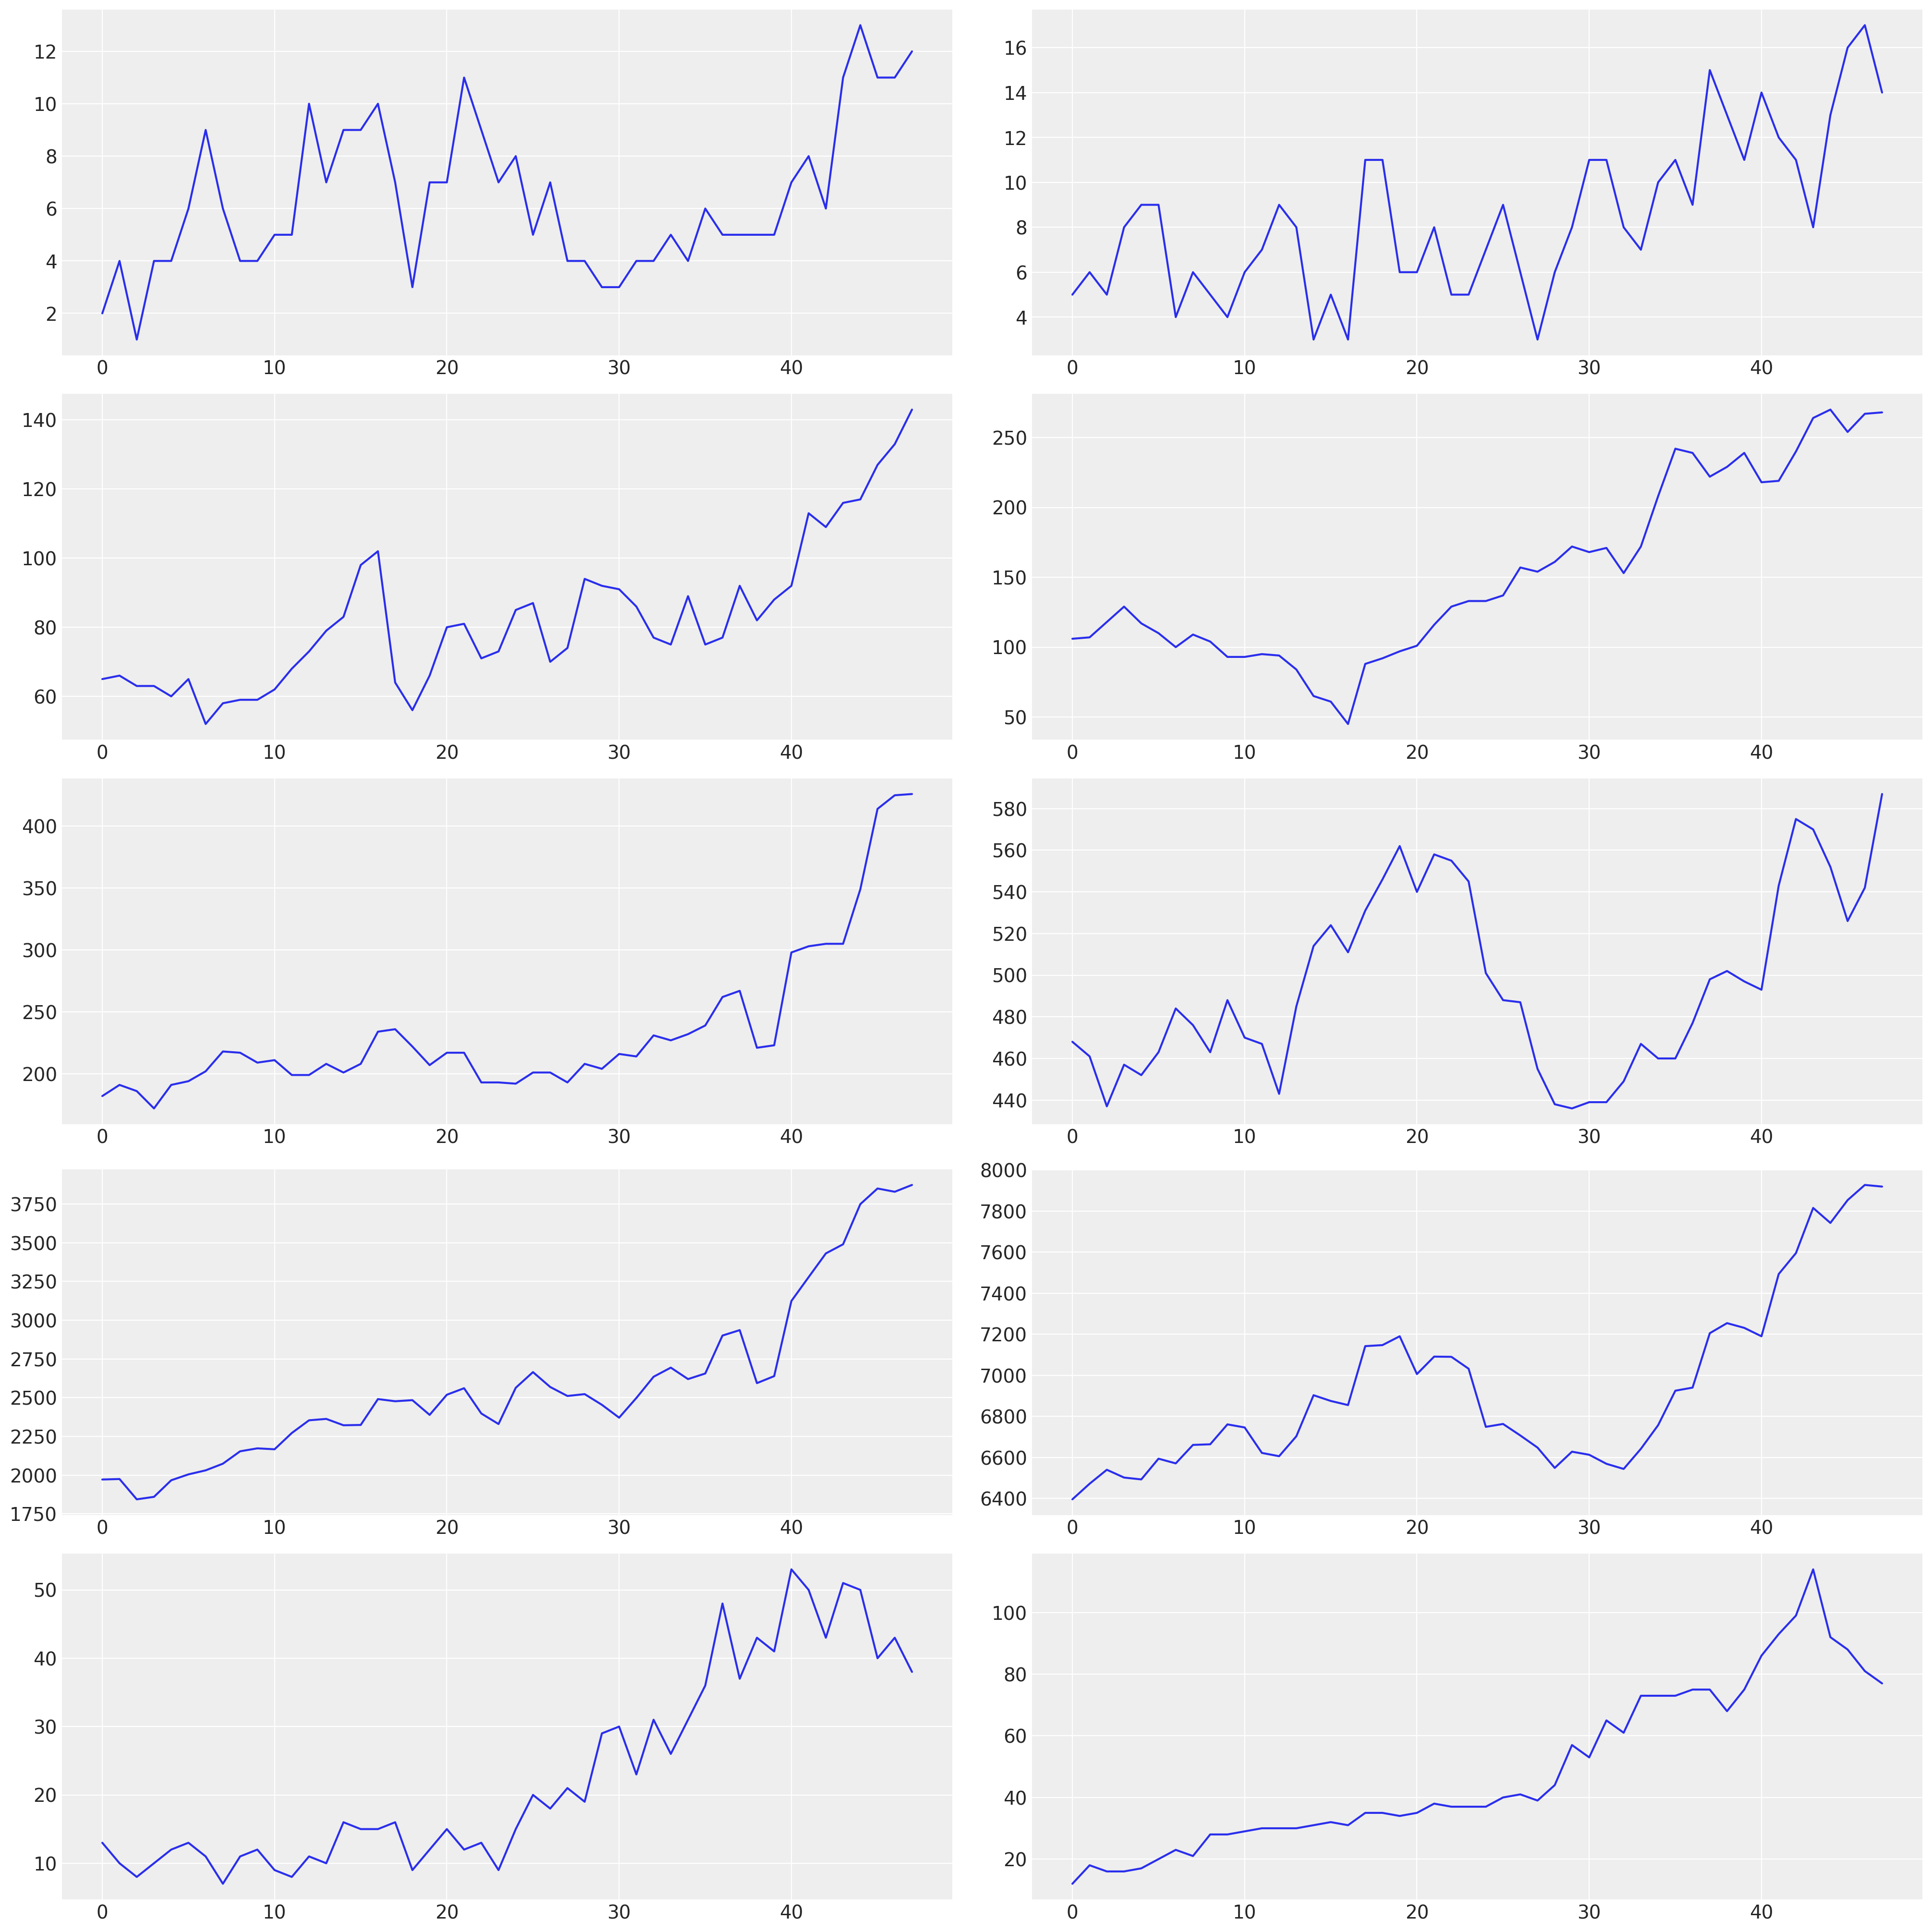

In [89]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

ax = ax.ravel()

for i in range(10):
    ax[i].plot(groups['predict']['data'][:,i])

We are adding normaly distributed noise to the data and for every 5 points in 100 we are creating an outlier. To define the outlier we use a uniform distribution from 1.5 to 2 times the median (< or > U(1.5,2) $\cdot$ median).

$$\begin{align}
I_{ij} &= \text{Bern}(0.5) \\
N_{ij} &= \mathcal{N}(0, \frac{\sigma_{Z_j}}{2}) \\
O_{ij} &= \text{Bern}(0.05) \\
M_{ij} &= \text{U}(1.5, 2) \\
Y_{ij} &= \max{(Z_{ij} + N_{ij} + O_{ij} \cdot median(Z_j) \cdot (M_{ij} \cdot I_{ij} - M_{ij} \cdot (1-I_{ij}), \textbf{0})}
\end{align}$$

In [90]:
μ_noise = 0
σ_noise = np.std(groups['predict']['data'], axis=0)/2

I = stats.bernoulli.rvs(0.5, size=(groups['predict']['n'],groups['predict']['s']))
O = stats.bernoulli.rvs(0.05, size=(groups['predict']['n'], groups['predict']['s']))
N = np.random.normal(μ_noise, σ_noise, size=(groups['predict']['n'], groups['predict']['s']))

data_w_noise = (np.maximum(np.round(groups['predict']['data'] + N + O 
                * np.median(groups['predict']['data'][:,0]) * (1.5 * I - 1.5*(1-I)),0), np.zeros((groups['predict']['n'], groups['predict']['s']))))

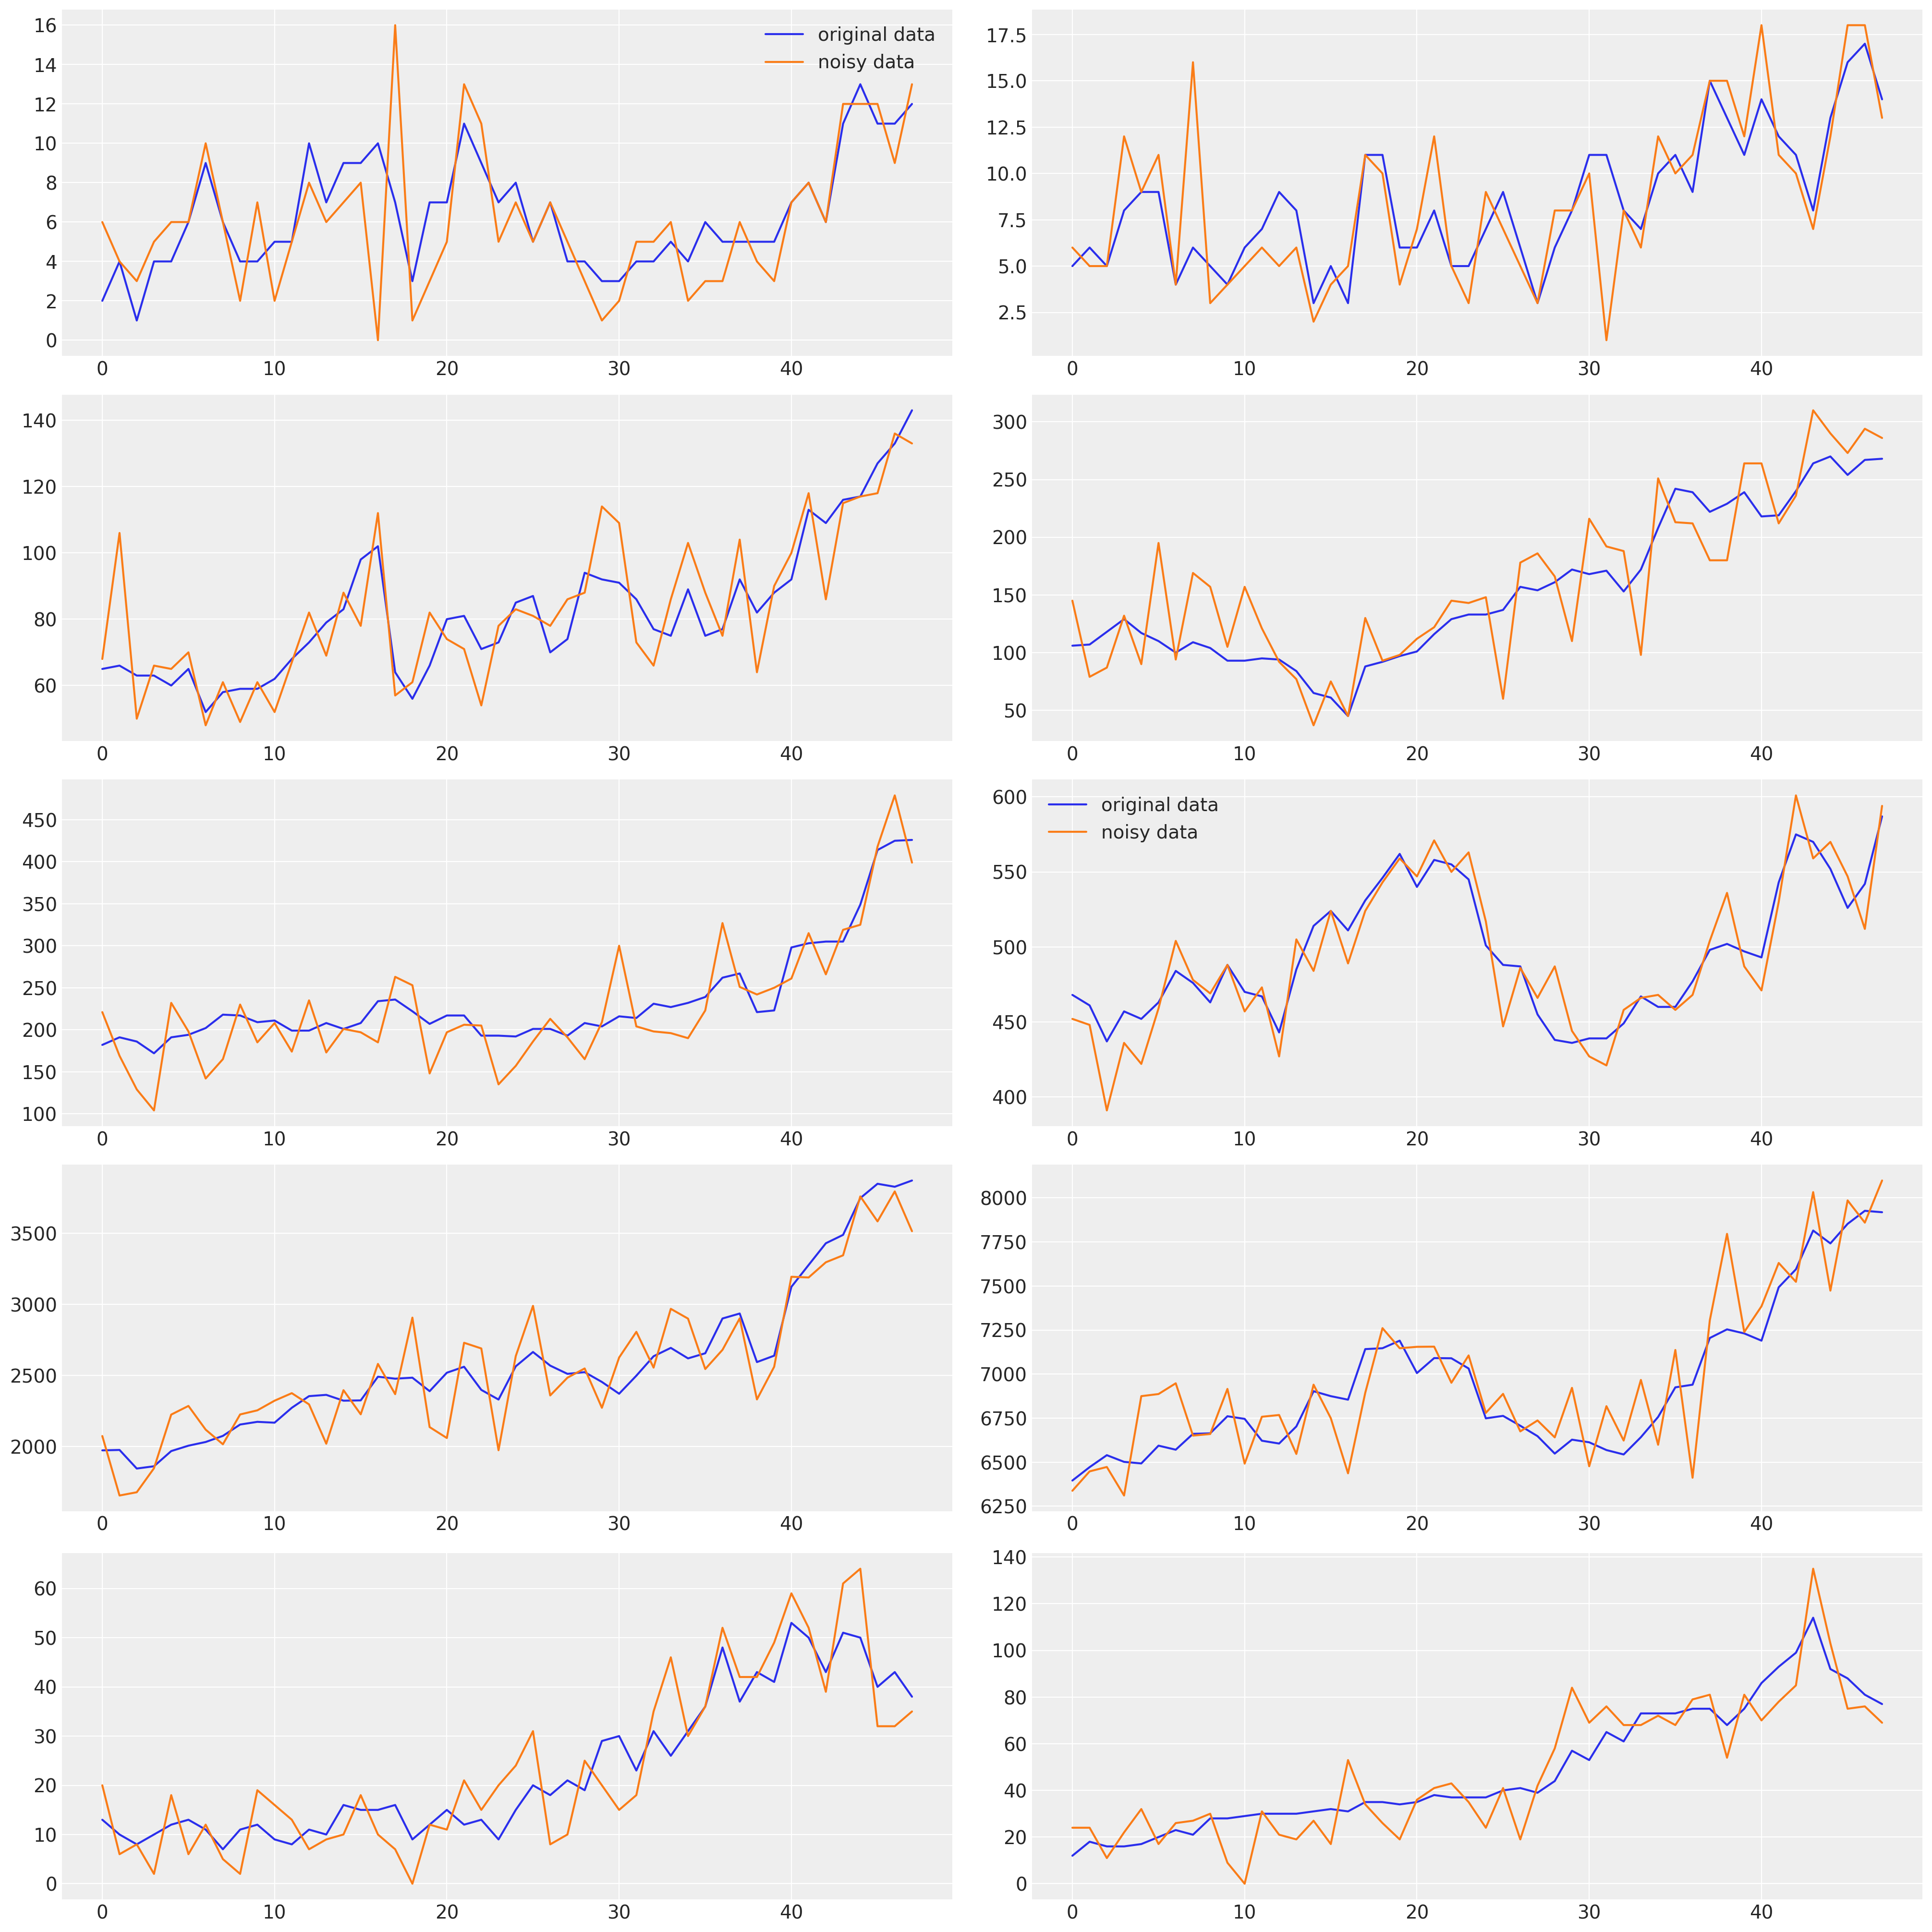

In [91]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

ax = ax.ravel()

for i in range(10):
    ax[i].plot(np.arange(groups['predict']['n']),groups['predict']['data'][:,i], label='original data')
    ax[i].plot(np.arange(groups['predict']['n']), data_w_noise[:,i], label='noisy data')
    if i%5==0:
        ax[i].legend()

In [92]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['Date'] = prison['t'].astype('datetime64[ns]')
prison = prison.drop('t', axis=1)
prison = prison.set_index('Date')
prison.columns= ['State', 'Gender', 'Legal', 'Count']

In [93]:
prison['data_w_noise'] = data_w_noise.T.reshape((-1,))

In [94]:
prison = prison.drop(columns=['Count'])
prison = prison.rename(columns={'data_w_noise': 'Count'})

In [95]:
prison.to_csv('../data/prison_task2_to_r.csv')